In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

from classical_shadow import sample_measurements, NQS, nll_batch

El objetivo principal del modelo de Deep Learning que implementaremos es ser capaz de estimar la amplitud y fase de probabilidad, es decir,
\begin{equation}
\nonumber
\psi_{\lambda}(0) = \langle 0 | \psi_{\lambda} \rangle =\sqrt{p_{\lambda}(0)} e^{\phi_{\lambda}(0)}, \qquad \psi_{\lambda}(1) = \langle 1 | \psi_{\lambda} \rangle =\sqrt{p_{\lambda}(1)} e^{\phi_{\lambda}(1)}.
\end{equation}

En principio, necesitamos un total de 4 parámetros reales para representar un estado de 1-qubit dados por $p_{\lambda}(0)$, $p_{\lambda}(1)$, $\phi_{\lambda}(0)$ y $\phi_{\lambda}(1)$. Podemos reducir la cantidad de parámetros necesarios a 2 usando propiedades de normalización y fase global. De esta forma, la cantidad de parametros necesarios se reduce a una amplitud $\sqrt{p_{\lambda}}$ y una fase $\psi_{\lambda}$. 

Luego, dado que nosotros usaremos información experimental idealizada para implementar nuestra tomografía, escribiremos el estado en múltiples bases para poder adaptar nuestros outcomes con los outcomes del modelo.

### ------------------------------------
### Paso 1, construir nuestro estado target aleatorio
### ------------------------------------

Construimos un estado puro aleatorio dada una parametrización que requiere dos ángulos,
\begin{equation}
\nonumber
\psi_{\mathrm{teo}} = \cos(\theta) \ | 0 \rangle + e^{i \phi} \sin(\theta) \ | 1 \rangle.
\end{equation}

In [2]:
# Elegimos dos parámetros aleatorios
theta   = torch.rand(1) * 2 * np.pi
phi     = torch.rand(1) * 2 * np.pi

# Definimos el estado objetivo
psi_teo = torch.tensor([np.cos(theta/2), np.sin(theta/2) * np.exp(1j*phi)]).reshape(-1,1)
print(psi_teo)

tensor([[0.9847+0.0000j],
        [0.0963-0.1454j]])


### ------------------------------------
### Paso 2, generamos nuestra data experimental simulada
### ------------------------------------
Para suministrar al modelo de información útil para entrenar necesitamos un conjunto de datos de la forma $(s, B)$, donde $s$ son los resultados de cada medición y $B$ la base que usamos para medir nuestro nuestro estado. En nuestro caso $B \in \{ X, Y, Z \}$. 



El objetivo es, dado que el estado lo consideramos que viene en la base lógica, podemos diferenciar 3 casos:
- Si queremos medir en $\sigma_z$, aplicamos $U = \mathcal{I}$
- Si queremos medir en $\sigma_x$ (base diagonal), aplicamos $U = H$
- Si queremos medir en $\sigma_y$ (base circular), aplicamos $U = S^{\dagger} H$

donde $H$ es la Hadamard y $S$ la phase gate.

In [3]:
# Generamos un dateset de medidas aleatorias
# Cada medida es en una base aleatoria (X Y Z) con probabilidad (1/3, 1/3, 1/3)
n_exp   = 500
dataset = sample_measurements(psi_teo, M = n_exp, probs_bases = (1/3, 1/3, 1/3))

In [4]:
def flip_dataset(dataset, p: float):
    new_dataset = []  # Aquí se almacenará el dataset con posibles flips.

    elements_error = int(len(dataset) * p)  
    # Calcula cuántos elementos del dataset se van a invertir.
    # Ojo: siempre serán los primeros `elements_error`.

    for _ in range(len(dataset)):
        if _ < elements_error:
            bit, basis = dataset[_]

            # Si el bit es 0, lo cambia a 1; si es 1, lo cambia a 0.
            if bit.item() == 0:
                new_bit = 1
            else:
                new_bit = 0

            # Crea una nueva tupla con el bit invertido y la misma base.
            new_tupla = (torch.tensor([new_bit]), basis)
            new_dataset.append(new_tupla)
        else:
            # Si no está en la parte de errores, lo deja igual.
            new_dataset.append(dataset[_])
    
    random.shuffle(new_dataset)  # Mezcla el dataset para que los errores no estén al principio.
    return new_dataset  # Devuelve la nueva lista con algunos flips

In [5]:
# Luego modificamos el dataset para incluir errores
dataset = flip_dataset(dataset, p = 0.25)

# Dividimos el dataset en train y test
split       = int(0.8 * len(dataset))
train_data  = dataset[:split]
test_data   = dataset[split:]

train_data[:10]

[(tensor([0]), 'X'),
 (tensor([0]), 'Z'),
 (tensor([0]), 'Z'),
 (tensor([0]), 'Z'),
 (tensor([0]), 'X'),
 (tensor([0]), 'X'),
 (tensor([0]), 'X'),
 (tensor([0]), 'Z'),
 (tensor([1]), 'Y'),
 (tensor([0]), 'Z')]

In [6]:
# Preparamos una función para crear cada minibatch para entrenar el modelo
def batches(lst, bs):
    """
    Yield successive mini-batches of size `bs` from a list.

    Args:
        lst: list, the dataset to be split into batches.
        bs: int, batch size.

    Yields:
        list, a slice of `lst` containing up to `bs` elements.
    """
    for i in range(0, len(lst), bs):
        yield lst[i:i+bs]

Para realizar el entrenamiento es necesario construir una función, a partir de los parámetros del modelo, a optimizar. Para este caso usaremos la Negative-Log-Likelihood dada por,
\begin{equation}
\nonumber
\mathcal{L}_{\lambda} \approx -\frac{1}{|N_{\mathrm{train}}|} \sum_{|s, B \rangle \in D_{\mathrm{Train}}} \log_2 \ p_{\psi_{\lambda}} (s, B),
\end{equation}
donde $\lambda$ representan los parámetros del modelo y, la probabilidad de medir un salida $s$ del estado $\psi$ después de rotarlo a la base $B$ se define como
\begin{equation}
\nonumber
p_{\psi_{\lambda}} (s, B) = \left| 
   \sum_{\substack{t \in \{0,1\}^n \\ \langle s,B|t\rangle \neq 0}} 
      \langle s,B|t\rangle \langle t|\psi_\lambda\rangle 
\right|^2
\end{equation}

In [7]:
# Entrenamos nuestro modelo para que ajuste sus parámetros de tal forma que pueda describir la estadistica de nuestro estado
model   = NQS()
opt     = torch.optim.Adam(model.parameters(), lr=1e-2)
sched   = scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=200, gamma=0.5)
epochs  = 500
batch   = 64

loss_train  = []
loss_test   = []

# Entrenamiento
for epoch in range(1, epochs + 1):
    model.train() # Set el modelo para entrenar
    losses = []

    for _ in batches(train_data, batch):
        loss = nll_batch(model, _) # Calculamos la función de pérdida para el batch elegido

        opt.zero_grad() # Limpiamos los gradientes
        loss.backward() # Calculamos los gradientes
        opt.step()  # Actualizamos los parámetros del modelo
        losses.append(loss.item())

    sched.step() # Actualizamos la tasa de aprendizaje

    # validación
    model.eval()
    with torch.no_grad():
        val_loss = nll_batch(model, test_data).item()

    loss_train.append(np.mean(losses))
    loss_test.append(val_loss)

    if epoch % 50 == 0 or epoch == 1 or epoch == epochs:
        print(f"Epoch {epoch:3d} | train NLL: {np.mean(losses):.6f} | val NLL: {val_loss:.6f}")

Epoch   1 | train NLL: 2.685085 | val NLL: 1.850732
Epoch  50 | train NLL: 1.108956 | val NLL: 1.168355
Epoch 100 | train NLL: 1.085945 | val NLL: 1.181280
Epoch 150 | train NLL: 1.073936 | val NLL: 1.172362
Epoch 200 | train NLL: 1.049200 | val NLL: 1.141278
Epoch 250 | train NLL: 1.039816 | val NLL: 1.127804
Epoch 300 | train NLL: 1.037572 | val NLL: 1.125903
Epoch 350 | train NLL: 1.037245 | val NLL: 1.127183
Epoch 400 | train NLL: 1.037206 | val NLL: 1.128031
Epoch 450 | train NLL: 1.037186 | val NLL: 1.128246
Epoch 500 | train NLL: 1.037187 | val NLL: 1.128377


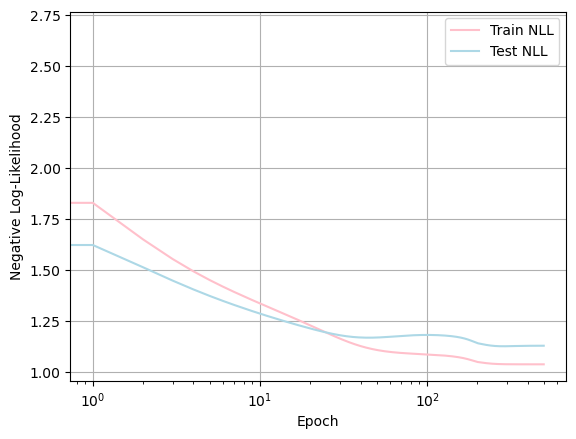

In [8]:
# Para determinar si todo salión bien, una forma de verificar es observar la variación de la función de pérdida durante el entrenamiento
plt.plot(loss_train, label='Train NLL', color="pink")
plt.plot(loss_test, label='Test NLL', color="lightblue")
plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.legend()
plt.grid()

plt.show()

In [9]:
# Observamos los parámetros obtenidos y los comparamos con los usados para generar la data. Además, calculamos la fidelidad entre el estado teórico y el estimado en la tomografía

psi_est = model.statevector() # Obtenemos el psi del modelo
braket  = (psi_teo.conj().T @ psi_est).squeeze()
fid     = (braket.conj()*braket).real.item() # Calculamos la fidelidad

# Comparamos también los parámetros del estado
al, probs = model.alphas()
phi0, phi1 = model.phases.tolist()

# Mostramos los resultados
print("\n=== Resultado ===")
print(f"Fidelidad obtenida : {fid:.6f}")


=== Resultado ===
Fidelidad obtenida : 0.980124
